# Predicting german words using tsBERT (TongueSwitcher)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# local modules import
import sys

sys.path.append("..")

In [3]:
import json
import pickle
import random as rnd
from tqdm import tqdm
from operator import itemgetter

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt


import torch
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss
import torch.nn.functional as F
from torch.nn.functional import softmax
from torch.utils.data import Dataset, DataLoader

import transformers
from transformers import AutoTokenizer, AutoModelForTokenClassification

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

from data_loading import create_word_lists, tidy_sentence_length
from tsBERT_data_processing import *

## Loading the data

### Loading the corpus

In [4]:
with open("../data/corpus_data.json") as json_file:
    data = json.load(json_file)
records = data["records"]

In [5]:
human_transcripts = [entry["human_transcript"] for entry in records]
stt_transcripts = [entry["stt_transcript"] for entry in records]

In [6]:
# human-transcribed words, STT transcribed words, language labels, semantical errors, grammatical errors
human_words, stt_words, word_labels, word_grams, word_sems = create_word_lists(records)

In [7]:
stt_transcripts, stt_words, labels, word_grams, word_sems = tidy_sentence_length(
    stt_transcripts, stt_words, word_labels, word_grams, word_sems
)

In [8]:
# convert boolean labels from True to 1 and from False to 0
labels = [[1 if label else 0 for label in record_labels] for record_labels in labels]

### Loading synthetic dataset augmented with German language elements

In [9]:
data_path = "../data/"

# reading the data from the files
with open(data_path + "words_higher_perc.pkl", "rb") as file:
    stt_synthetic_words = pickle.load(file)

with open(data_path + "labels_higher_perc.pkl", "rb") as file:
    synthetic_labels = pickle.load(file)

# convert boolean labels from True to 1 and from False to 0
synthetic_labels = [
    [1 if label else 0 for label in record_labels] for record_labels in synthetic_labels
]

## Quick Corpus Exploration

In [10]:
print(f"There are {len(records)} transcripts in total.")

There are 6723 transcripts in total.


In [11]:
nb_words_per_record = [len(record["words"]) for record in records]

In [12]:
print(f"The minimum number of words in any transcript is {min(nb_words_per_record)}.")
print(f"The maximum number of words in any transcript is {max(nb_words_per_record)}.")
print(
    f"The median number of words across all transcripts is {int(np.median(nb_words_per_record))}."
)

The minimum number of words in any transcript is 1.
The maximum number of words in any transcript is 517.
The median number of words across all transcripts is 6.


<Figure size 432x288 with 0 Axes>

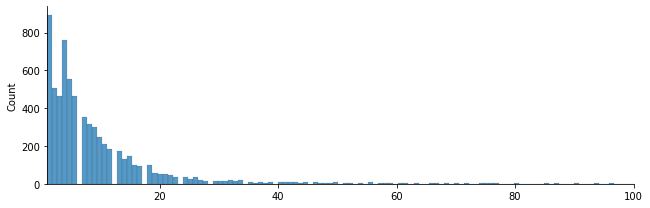

In [13]:
# plot the distribution of word counts
plt.figure(figsize=(6, 4))
sns.displot(nb_words_per_record, orientation="horizontal", height=3, aspect=3)
plt.xlim(1, 100)
plt.show()

In [14]:
german_proportion, total_tokens = calculate_label_proportions(word_labels)
print(
    f"There are {total_tokens} words in total out of which only {german_proportion*100:.2f}% are german."
)

There are 62305 words in total out of which only 3.00% are german.


## Data Preprocessing and Data Labelling

In [15]:
# load the tsBERT model and the tokenizer
model_name = "igorsterner/german-english-code-switching-identification"
model = AutoModelForTokenClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

### Transcripts Processing

In [16]:
######################
### SET PARAMETERS ###
######################

window_size = 0
batch_size = 8
max_length = 268

In [17]:
# compute the contextual input with labels
contextual_stt_input, contextual_labels = create_contextual_input_with_labels(
    stt_words, labels, window_size=window_size
)
(
    contextual_stt_synthetic_input,
    contextual_synthetic_labels,
) = create_contextual_input_with_labels(
    stt_synthetic_words, synthetic_labels, window_size=window_size
)

In [18]:
# set the desired total length for BERT embeddings (to make sure they are the same between train-validation-test sets)

# tokenize the STT-transcribed transcripts using the BERT tokenizer
tokenized_inputs = tokenizer(
    contextual_stt_input,
    truncation=True,
    # padding=True,
    padding="max_length",
    is_split_into_words=True,
    max_length=max_length,
)

tokenized_synthetic_inputs = tokenizer(
    contextual_stt_synthetic_input,
    truncation=True,
    padding="max_length",
    is_split_into_words=True,
    max_length=max_length,
)

### Label Alignement
- we adjust the labels: since we add context (neighbour transcripts) and [SEP] tokens as input the the model, we also also need to adjust out labels to align with the new token structure.
- we assign an ignore index (-100) to these separator tokens since they don't carry meaningful language labels.

In [19]:
# align the labels so that they are suitable for the tsBERT model
tsBERT_labels = preprocess_labels(tokenized_inputs, contextual_labels)
tsBERT_synthetic_labels = preprocess_labels(
    tokenized_synthetic_inputs, contextual_synthetic_labels
)

## tsBERT Evaluation

In [20]:
class STTDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [21]:
window_sizes = [0, 1, 2, 3, 4]
batch_sizes = [8, 16, 3]
max_length = 268

for batch_size in batch_sizes:
    for window_size in window_sizes:
        # compute the contextual input with labels
        contextual_stt_input, contextual_labels = create_contextual_input_with_labels(
            stt_words, labels, window_size=window_size
        )
        # contextual_stt_synthetic_input, contextual_synthetic_labels = create_contextual_input_with_labels(stt_synthetic_words, synthetic_labels, window_size=window_size)

        # tokenize the STT-transcribed transcripts using the BERT tokenizer
        tokenized_inputs = tokenizer(
            contextual_stt_input,
            truncation=True,
            # padding=True,
            padding="max_length",
            is_split_into_words=True,
            max_length=max_length,
        )

        # align the labels so that they are suitable for the tsBERT model
        tsBERT_labels = preprocess_labels(tokenized_inputs, contextual_labels)

        # convert the tokenized input and label sets into a format suitable for training (datasets)
        full_dataset = STTDataset(tokenized_inputs, tsBERT_labels)
        # full_synthetic_dataset = STTDataset(tokenized_synthetic_inputs, tsBERT_synthetic_labels)

        # prepare the DataLoaders
        full_loader = DataLoader(full_dataset, batch_size=batch_size, shuffle=True)

        # full_synthetic_loader = DataLoader(full_synthetic_dataset,
        #                                   batch_size=batch_size,
        #                                   shuffle=True)

        ### tsBERT EVALUATION ###
        print(f"Window size: {window_size}, Batch size: {batch_size}")
        eval_results = evaluate(model, full_loader)
        print(eval_results)

Window size: 0, Batch size: 8


KeyboardInterrupt: 

## Train-Validation-Test Split

### 80-20 Train-Test Split

We need to extract which sentences contain German words in order to stratify the data split:

In [22]:
stat_labels = [
    [True if (label == 1) else False for label in record_labels]
    for record_labels in tsBERT_labels
]
stat_labels = np.any(stat_labels, axis=1)

Here, we split only indices and not data itself:

In [23]:
indices = list(range(len(stt_transcripts)))
tr_indices, te_indices = train_test_split(
    indices, test_size=0.2, random_state=0, shuffle=True, stratify=stat_labels
)

In [24]:
extract_train = itemgetter(*tr_indices)
extract_test = itemgetter(*te_indices)

In [25]:
tr_contextual_stt_input = list(extract_train(contextual_stt_input))
tr_tsBERT_labels = list(extract_train(tsBERT_labels))
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
te_contextual_stt_input = list(extract_test(contextual_stt_input))
te_tsBERT_labels = list(extract_test(tsBERT_labels))

### 90-10 Train-Validation Split

In [26]:
stat_labels = [
    [True if (label == 1) else False for label in record_labels]
    for record_labels in tr_tsBERT_labels
]
stat_labels = np.any(stat_labels, axis=1)

In [27]:
indices = list(range(len(tr_contextual_stt_input)))
tr_indices, val_indices = train_test_split(
    indices, test_size=0.1, random_state=0, shuffle=True, stratify=stat_labels
)

In [28]:
extract_train = itemgetter(*tr_indices)
extract_val = itemgetter(*val_indices)

In [29]:
tr_val_contextual_stt_input = tr_contextual_stt_input.copy()
tr_val_tsBERT_labels = tr_tsBERT_labels.copy()

tr_contextual_stt_input = list(extract_train(tr_val_contextual_stt_input))
tr_tsBERT_labels = list(extract_train(tr_val_tsBERT_labels))
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
val_contextual_stt_input = list(extract_val(tr_val_contextual_stt_input))
val_tsBERT_labels = list(extract_val(tr_val_tsBERT_labels))

## tsBERT fine-tuning

In [30]:
# set the desired total length for BERT embeddings (to make sure they are the same between train-validation-test sets)
train_inputs = tokenizer(
    tr_contextual_stt_input,
    truncation=True,
    # padding=True,
    padding="max_length",
    is_split_into_words=True,
    max_length=max_length,
)

validation_inputs = tokenizer(
    val_contextual_stt_input,
    truncation=True,
    padding="max_length",
    is_split_into_words=True,
    max_length=max_length,
)

test_inputs = tokenizer(
    te_contextual_stt_input,
    truncation=True,
    padding="max_length",
    is_split_into_words=True,
    max_length=max_length,
)

train_labels = tr_tsBERT_labels
validation_labels = val_tsBERT_labels
test_labels = te_tsBERT_labels

In [31]:
# convert the tokenized input and label sets into a format suitable for training (datasets)
train_dataset = STTDataset(train_inputs, train_labels)
validation_dataset = STTDataset(validation_inputs, validation_labels)
test_dataset = STTDataset(test_inputs, test_labels)

In [34]:
# define hyperparameter grid
learning_rates = [5e-5, 3e-5, 3e-5]  # BERT authors recommend 3e-4, 1e-4, 5e-5, 3e-5
batch_sizes = [16, 32]  # BERT authors recommend 8, 16, 32, 64, 128
num_epochs = 4

In [ ]:
# storage for all model results
all_results = []

# hyperparameter Tuning Loop
for lr in learning_rates:
    for batch_size in batch_sizes:
        # initialize model
        model = AutoModelForTokenClassification.from_pretrained(model_name)

        # GPU Acceleration
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = model.to(device)

        # initialize optimizer and loss function for each combination
        optimizer = AdamW(model.parameters(), lr=lr)
        loss_function = CrossEntropyLoss(ignore_index=-100)

        # prepare the DataLoaders
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        validation_loader = DataLoader(validation_dataset, batch_size=batch_size)
        test_loader = DataLoader(test_dataset, batch_size=batch_size)

        # train and validate the model
        results = train_and_validate(
            model,
            train_loader,
            validation_loader,
            num_epochs,
            optimizer,
            loss_function,
            device,
        )

        # store results
        all_results.append([lr, batch_size, results])

Training
Epoch 1/4
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  1%|▍                                          | 3/306 [00:19<33:15,  6.59s/it]


In [ ]:
# convert the list of results to a pandas DataFrame
all_results_df = pd.DataFrame.from_records(
    [
        {
            "learning_rate": lr,
            "batch_size": bs,
            "epoch": r["epoch"],
            "train_loss": r["avg_train_loss"],
            "val_loss": r["avg_test_loss"],
            "val_accuracy": r["accuracy"],
            "val_precision": r["precision"],
            "val_recall": r["recall"],
            "val_f1": r["f1"],
        }
        for lr, bs, result_list in all_results
        for r in result_list
    ]
)

# save to CSV
all_results_df.to_csv("../data/" + output_filename + ".csv", index=False)

In [ ]:
all_results_df